In [1]:
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk
from sklearn.cluster import KMeans

[[4.51346296 4.58969516 4.58637523 ... 4.58478931 4.51843191 4.49467869]
 [4.52788707 4.60171072 4.59366468 ... 4.57692825 4.56230367 4.50249563]
 [4.53751182 4.57559995 4.60423638 ... 4.6323113  4.63745483 4.5740619 ]
 ...
 [4.54906586 4.58216603 4.57640446 ... 4.56853889 4.59623454 4.59869157]
 [4.54185183 4.55082117 4.55754687 ... 4.59633212 4.57511726 4.58533698]
 [4.49994588 4.5399181  4.57930423 ... 4.56988853 4.59495227 4.57278095]]


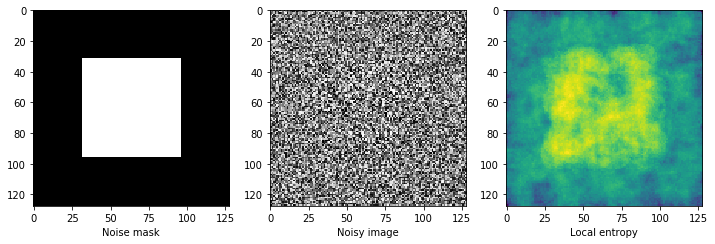

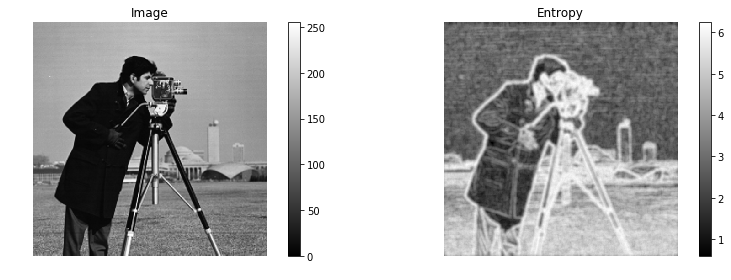

In [2]:
#https://scikit-image.org/docs/dev/auto_examples/filters/plot_entropy.html

noise_mask = np.full((128, 128), 28, dtype=np.uint8)
noise_mask[32:-32, 32:-32] = 30

noise = (noise_mask * np.random.random(noise_mask.shape) - 0.5 *
         noise_mask).astype(np.uint8)
img = noise + 128

entr_img = entropy(img, disk(10))
print(entr_img)
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

ax0.imshow(noise_mask, cmap='gray')
ax0.set_xlabel("Noise mask")
ax1.imshow(img, cmap='gray')
ax1.set_xlabel("Noisy image")
ax2.imshow(entr_img, cmap='viridis')
ax2.set_xlabel("Local entropy")

fig.tight_layout()

# Second example: texture detection.

image = img_as_ubyte(data.camera())

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4),
                               sharex=True, sharey=True)

img0 = ax0.imshow(image, cmap=plt.cm.gray)
ax0.set_title("Image")
ax0.axis("off")
fig.colorbar(img0, ax=ax0)

img1 = ax1.imshow(entropy(image, disk(5)), cmap='gray')
ax1.set_title("Entropy")
ax1.axis("off")
fig.colorbar(img1, ax=ax1)

fig.tight_layout()

plt.show()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


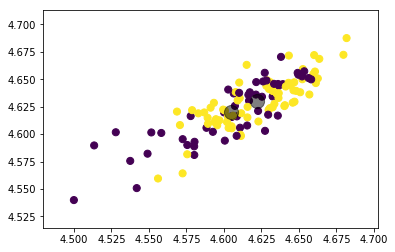

In [3]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(entr_img)
y_kmeans = kmeans.predict(entr_img)

plt.scatter(entr_img[:, 0], entr_img[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

print(y_kmeans)

In [4]:
import cv2
from pywt import dwt2

#im = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, (cH, cV, cD) = dwt2(image.T, 'db1')
# a - LL, h - LH, v - HL, d - HH as in matlab
Energy = (cH**2 + cV**2 + cD**2).sum()/image.size

print (Energy)

50.19047355651857


In [5]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""This program is a demonstration of image segmentation.
The following key bindings are available:
  O - display the original image
  S - display the segmented image
  L - display the largest segment
  Q - exit
"""

import argparse
import os
import sys

sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('.'))

import cv2
import numpy as np

import common
import imgpheno as ft

def main():
    print (__doc__)

    parser = argparse.ArgumentParser(description='Test image segmentation')
    parser.add_argument('image', metavar='FILE', help='Input image')
    parser.add_argument('--iters', metavar='N', type=int, default=5, help="The number of grabCut iterations. Default is 5.")
    parser.add_argument('--margin', metavar='N', type=int, default=1, help="The margin of the foreground rectangle from the edges. Default is 1.")
    parser.add_argument('--max-size', metavar='N', type=float, help="Scale the input image down if its perimeter exceeds N. Default is no scaling.")
    parser.add_argument('--algo', metavar='simple|grabcut', type=str, choices=['simple', 'grabcut'], default='grabcut', help="The segmentation algorithm to use, either 'simple' or 'grabcut'.")
    parser.add_argument('--roi', metavar='x,y,w,h', type=str, help="Region Of Interest, expressed as X,Y,Width,Height in pixel units.")
    args = parser.parse_args()

    img = cv2.imread(args.image)
    if img == None or img.size == 0:
        sys.stderr.write("Failed to read %s\n" % args.image)
        return -1

    sys.stderr.write("Processing %s...\n" % args.image)

    # Scale the image down if its perimeter exceeds the maximum (if set).
    img = common.scale_max_perimeter(img, args.max_size)

    # Process region of interest argument
    roi = None
    if args.roi != None:
        roi = args.roi.split(',')
        roi[0] = int(roi[0])
        roi[1] = int(roi[1])
        roi[2] = int(roi[2])
        roi[3] = int(roi[3])

    # Perform segmentation.
    if args.algo == 'grabcut':
        mask = common.grabcut(img, args.iters, roi, args.margin)
    else:
        mask = common.simple(img, roi)

    # Create a binary mask. Foreground is made white, background black.
    bin_mask = np.where((mask==cv2.GC_FGD) + (mask==cv2.GC_PR_FGD), 255, 0).astype('uint8')

    # Create a binary mask for the largest contour.
    contour = ft.get_largest_contour(bin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask_contour = np.zeros(bin_mask.shape, dtype=np.uint8)
    cv2.drawContours(mask_contour, [contour], 0, 255, -1)
    cv2.drawContours(img, [contour], 0, common.COLOR['green'], 1)

    # Merge the binary mask with the image.
    img_masked = cv2.bitwise_and(img, img, mask=bin_mask)
    img_masked_contour = cv2.bitwise_and(img, img, mask=mask_contour)

    # Display the image in a window.
    cv2.namedWindow('image')
    cv2.imshow('image', img_masked)

    while True:
        k = cv2.waitKey(0) & 0xFF

        if k == ord('o'):
            cv2.imshow('image', img)
        elif k == ord('s'):
            cv2.imshow('image', img_masked)
        elif k == ord('l'):
            cv2.imshow('image', img_masked_contour)
        elif k == ord('q'):
            break

    cv2.destroyAllWindows()

    return 0

if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'common'